# Randomized Algorithms for Linear Systems

All the labs will be in the Julia language. Think of Julia as a language which is nearly as fast as C, while being as easy to work with as MATLAB. Presumably most of you have not worked with Julia before - do not worry about it, you will pick it up during the course. 

In this lab, the randomized iterative method of Gower and Richtarik for solving linear systems has been coded up for you. We are using the Julia notebook interface - the notebook is composed of three cell types: heading, markdown (containing text and LaTeX, such as this cell) and code (contaning actual Julia code that can be executed). You can execute each active "cell" by pressing the play button in the menu above, or by pressing "shift + enter". The cells in this notebook need to be executed in order.

Play with the code and try to see what it does. There will be some exercices at the end. Do at least one - there will be no time to do (much) more than that in the lab. However, feel free to work on the other exercises at home.

## 1. Generate data

We first generate an $m\times n$ matrix $A$, then a random vector $x^*$ ($\verb"x_star"$) and finally, set $b = A x^*$. This way we will know the system we have generated is consistent (i.e., that it has a solution).

## 1.1 Silly synthetic data

In [84]:
srand(1) # set random seed to 1

m = 1000
n = 50

# Generate random matrix A

A = randn(m,n) # A has random standard normal entries. For uniform entries on [0,1], use rand() 
x_star = randn(n)
b = A*x_star

# Generate solution and the right hand side

xopt = ones(n,1)
b = A*xopt

1000x1 Array{Float64,2}:
  -0.153183
  -2.34837 
  -7.07596 
   8.9659  
  17.1319  
  -9.09333 
  -0.850716
  11.3664  
   2.15202 
  11.7419  
  -3.82589 
   4.54637 
   8.67222 
   ⋮       
   6.10183 
   3.29236 
  -3.43715 
 -15.9092  
  -3.23675 
  -0.271846
  -9.24254 
   7.46836 
  -6.5396  
  -6.30701 
   3.54236 
  -7.0734  

## 1.2 Smarter synthetic data (good for randomized Kaczmarz)

We now generate a matrix $A\in \mathbb{R}^{m\times n}$ such that the randomized Kaczmarz rate 

$$\rho =1 - \frac{\lambda_{min}(A^TA)}{\|A\|_F^2} = 1 - \frac{\lambda_{min}(A^TA)}{Tr(A^TA)}$$ 

is under control. Specifically, we shall select the eigenvalues of $A^T A$ first, and then construct a random matrix $A\in \mathbb{R}^{m\times n}$ whose spectrum is fixed this way.


The trick is to assemble $A$ via its SVD (singular value decomposition): 

$$A = U D V^T,$$

where $U\in \mathbb{R}^{m\times m}$ and $V\in \mathbb{R}^{n \times n}$ are orthonormal matrices and $D\in \mathbb{R}^{m\times n}$ is diagonal (that is, $D_{ij}=0$ for $i\neq j$). Note that given the SVD, we have 

$$A^T A = V D^T D V^T,$$  

and hence the eigenvalues of $A^T A$ are $D_{ii}^2$ for $i=1,2,\dots, \min\{m,n\}$. Hence, 

$$\rho = 1 - \frac{\min_i D_{ii}^2}{\sum_{i} D_{ii}^2}.$$

So, we first generate the eigenvalues $D_{ii}^2$, and then generate two random orthoginal matrices $U\in \mathbb{R}^{m\times m}$ and $V\in \mathbb{R}^{n\times n}$ by performing a QR decomposition of random matrices of appropriate sizes. After this, we simply assemble $A$ from these three components via $A = U D V^T$.


In [75]:
D = zeros(m,n)

for i=1:min(m,n)
    
  D[i,i] = 10 + rand()
    
end

lambda_min = minimum(diag(D'*D))
lambda_sum = sum(diag(D'*D))
rho = 1- lambda_min/lambda_sum
println("rho = ",rho)

(U,RU) = qr(randn(m,m))
(V,RV) = qr(randn(n,n))
A = U*D*V'

x_star = randn(n)
b = A*x_star

# C = A'*A
# lambda_min = minimum(eigvals(C))
# lambda_sum = sum(eigvals(C))
# rate = 1 - lambda_min/tr
# println(rate)

rho = 0.9818054911530927


1000-element Array{Float64,1}:
  2.59111   
 -0.556459  
 -0.17882   
  0.402689  
 -0.278817  
 -2.70223   
 -0.263991  
 -2.0643    
 -0.179974  
  1.89966   
 -2.52629   
 -3.90315   
 -1.5513    
  ⋮         
 -0.985235  
  1.56159   
  4.84442   
 -0.74797   
  1.19115   
  1.15037   
 -1.76833   
 -1.09004   
 -0.205697  
  1.6215    
 -0.286106  
 -0.00876614

## 2. The Generic Solver

The two functions below implement the general version of the algorithm of Gower and Richtarik covered in the lecture today:

$$ x \leftarrow x - B^{-1} A^T S (S^T A B^{-1} A^T S)^\dagger S^T (Ax-b). $$

Recall that the general method has two parameters: an $n\times n$ positive definite matrix $B$ defining a norm, and a random matrix $S$ defining the "sketch". Matrix $S$ has to have the right dimensions such that one can perform the following multiplication: $S^T A$. That is, $S$ has to have $m$ rows. However, it can have an arbitrary number of columns (one, more, or even random).

In [83]:
function iterate(x, A, b, Binv, S)
    
    return x - Binv*A'*S*pinv(S'*A*Binv*A'*S)*S'*(A*x - b) # ' is the transpose operator, it has higher priority than *
    
end


function RandomLinearSolve(x, A, b, Binv, sampling, T, skip)
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # will remember the iterates x here
    fv = zeros(floor(Integer, T/skip) + 1)    # will remember residuals ||Ax-b|| here
    
    tic()
    time = 0
    
    for t=0:T
        tic()
        x = iterate(x, A, b, Binv, sampling()) # notice that the last argument is a function
        time = time + toq()
        if t % skip == 0
            xs[:,round(Int,t/skip)+1] = x           # remember iterate x
            fv[round(Int,t/skip)+1] = norm(A*x-b)   # remeber residual 
            println("iteration: $(t), residual: $(fv[round(Int,t/skip+1)]) ")
        end
    end
        
    println("Time = ", time)
    return xs,fv
    
end

RandomLinearSolve (generic function with 1 method)

## 3. Sampling

We now write a function which outputs a random matrix $S$ ("sampling/sketching") which is equal to a random coordinate vector in $\mathbb{R}^m$ chosen uniformly at random. Recall that both the randomized Kaczmarz and randomized coordinate descent methods utilize this sampling/sketching. Also notice that standard randomized Kaczmarz uses nonuniform probabilities. 

${\bf Problem:}$ You may want to modify the $\verb"sampling()"$ function so that the probabilities are proportional to the squared norms of the rows of $A$ -- as initially proposed by Strohmer and Vershynin.

In [77]:
function sampling() # for non-uniform sampling, looks into the function "sample" in the package StatsBase
    
    S = zeros(m)
    S[rand(1:m)] = 1 # rand(range) returns a random number in the given range
    return S
    
end

sampling (generic function with 1 method)

## 4. Plotting

In [78]:
using PyPlot

function PlotResults(B, x_star, xs, fv)
    
    ax = axes()
    plt[:plot](skip*(0:length(fv)-1), fv, "-", linewidth=3.0, label=L"||Ax - b||")
    plt[:plot](skip*(0:length(fv)-1), [sqrt((xs[:,i]-x_star)'*B*(xs[:,i]-x_star)) for i=1:length(fv)] , ":", linewidth=3.0, label=L"||x - x^*||_B")
    legend(loc="upper right")
    ylabel("error", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    
end

PlotResults (generic function with 1 method)

## 5. Solve the problem

iteration: 0, residual: 81.1318184147387 
iteration: 100, residual: 28.061538029857452 
iteration: 200, residual: 9.628608459636052 
iteration: 300, residual: 3.458002696700712 
iteration: 400, residual: 1.360105005354288 
iteration: 500, residual: 0.6028422855792183 
iteration: 600, residual: 0.18740359822190616 
iteration: 700, residual: 0.07124850229391667 
iteration: 800, residual: 0.023565613262080513 
iteration: 900, residual: 0.0108018985173459 
iteration: 1000, residual: 0.002734067263743863 
iteration: 1100, residual: 0.0007288292014233471 
iteration: 1200, residual: 0.00027077590111684955 
iteration: 1300, residual: 8.308808574697304e-5 
iteration: 1400, residual: 2.4203736115101168e-5 
iteration: 1500, residual: 9.112723002839596e-6 
iteration: 1600, residual: 3.519176341738644e-6 
iteration: 1700, residual: 1.2569289075821847e-6 
iteration: 1800, residual: 3.9096368662650536e-7 
iteration: 1900, residual: 1.5709454959284916e-7 
iteration: 2000, residual: 6.689231416177186e-

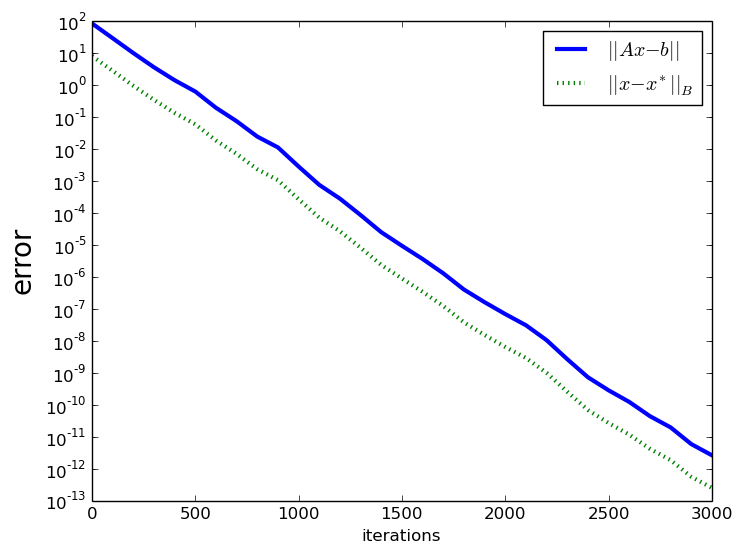

display_figs (generic function with 1 method)

In [82]:
x = zeros(n)  # initial iterate
Binv = eye(n) # matrix B is one of the 2 parameters of the method

T = 3*m       # no of iterations 
skip = 100    # we shall remember x each "skip" number of iterations

# Now we solve the problem
xs, fv = RandomLinearSolve(x, A, b, Binv, sampling, T, skip)

# Let us now plot the results
B = inv(Binv)
PlotResults(B, x_star, xs, fv)

## Problem A

Code up a dedicated randomized Kaczmarz solver. That is, do it in an efficient way so that one does not need to run the "iterate" function. Clearly, this function is rather inefficient - this is because it is so generic.

## Problem B

Code up a dedicated randomized coordinate descent solver. Test it on a random problem for which $A^T A$ is positive definite. Test the solver for two choices of probabilities: uniform and proportional to squared Euclidean norms of the columns of $A$, as covered in the lecture.

## Problem C

Code up the randomized Newton method. Do this for $S = I_{:C}$, where $C$ is a random subset of $\{1,2,\dots,n\}$ of fixed cardinality $\tau$ chosen uniformly at random. Test the method various choices of $\tau$. Find a $3\times 3$ matrix $A$ such that running the randomized Newton method with $\tau=2$ is vastly (= as much as you want) better than running it with $\tau=1$.

## Problem D

Code up and test the Gaussian descent variant of the method.

## Problem E

Can you come up with some other interesting sketching matrix $S$ not covered in the lecture? When would you use it? 